# Walkthrough - Gamma n Mutual Infor



In [16]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

import warnings
from typing import Optional, Tuple
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.distribution import DataParams, Inputs

# Kernel Dependency measure
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from models.dependence import HSICModel
from pysim.kernel.utils import estimate_sigma

# RBIG IT measures
# from models.ite_algorithms import run_rbig_models

# Plotting
from visualization.distribution import plot_scorer

# experiment helpers
from experiments.utils import dict_product, run_parallel_step
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-talk'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
!pwd

/home/emmanuel/projects/2019_hsic_align/notebooks/4_distributions


In [18]:
FIG_PATH = "/home/emmanuel/projects/2019_hsic_align/results/figures/distribution_experiment/mutual_info/"
RES_PATH = "/home/emmanuel/projects/2019_hsic_align/data/results/distributions/mutual_info/"

### Experimental Parameters

In [19]:
# initialize the holder for the parameters
parameters = {}

#### Case I - HSIC Estimator

In this first part, we have 3 cases of HSIC as a combination of a centered kernel and whether or not we normalize the covariance term. The 3 "scorers" are as follows:


1. **HSIC**

$$HSIC = \frac{1}{n(n-1)}\langle K_xH,K_yH \rangle_F$$

> In this case, the kernels are **centered**, but the score is **not normalized**.


2. **Kernel Alignment** (KA) 

$$TKA = \frac{\langle K_x,K_y \rangle_F}{||K_x||_F||K_y||_F}$$

> In this case, the kernels are **not centered** but the score is **normalized**.

3. **cTKA**

$$cTKA = \frac{\langle K_xH,K_yH \rangle_F}{||K_xH||_F||K_yH||_F}$$

> In this case, the kernels are **centered** and the score is **normalized**.

In [20]:
def get_hsic(
    X: np.ndarray, 
    Y: np.ndarray, 
    scorer: str, 
    sigma_X: Optional[float]=None, 
    sigma_Y: Optional[float]=None
) -> float:
    """Estimates the HSIC value given some data, sigma and
    the score."""
    # init hsic model class
    
    hsic_model = HSICModel()
    # hsic model params
    if sigma_X is not None:
        
        hsic_model.kernel_X = RBF(sigma_X)
        hsic_model.kernel_Y = RBF(sigma_Y)

    # get hsic score
    hsic_val = hsic_model.get_score(X, Y, scorer)
    
    return hsic_val

# parameters
parameters['scorer'] = ['hsic', 'ka', 'cka'] 

#### Case II - Sigma Estimator

For this parameter, we are interested in estimating a few things:

1. We want to know which estimator to choose from.

Kernel methods are great if the parameters of the kernel are correct. In supervised scenarios, we can simply learn the appropriate kernel parameters that best fit our data given some criteria. In unsupervised settings, we generally do not know which parameters to choose from. But there are many different ways to choose the parameters as every lab/researcher has their own method that "they swear by". I will choose some of the most common ones: 

* Silverman
* Scott
* Mean Distance
* Median Distance
* Median Distance with the $k^{th}$ sample (or percent) of that distance matrix.

#### Case III - Sigma Application

2. We want to know the how we are applying the length scale.

We have three cases to consider:

* One length scale for both datasets
* One length scale per dataset
* One length scale per dataset per dimension

This is important as it could turn a good estimator into a bad estimator. Scott and Silverman work very well for univariate distributions but not very well for multivariate distributions. So if we have one scott/silverman estimate per feature, then this estimator might be a lot better and yield much better results. For the case of the RBF kernel, having one length scale per dimension corresponds to the ARD Kernel which assigns a length scale (or relevance values) per feature. We don't typically use the ARD kernel for kernel methods that we cannot optimize using some gradient function due to how expensive it is. But in this case, it isn't so expensive because we are choosing not to optimizing anything.

In [22]:
def get_sigma(
    X: np.ndarray, 
    Y: np.ndarray, 
    method: str='silverman', 
    percent: Optional[float]=None,
    per_dimension: bool=False, 
    separate_scales: bool=False
) -> Tuple[np.ndarray, np.ndarray]:
    # sigma parameters
    subsample = None
    random_state = 123
    
    sigma_X = estimate_sigma(
        X, 
        subsample=subsample,
        method=method,
        percent=percent,
        random_state=random_state,
        per_dimension=per_dimension
    )
    
    sigma_Y = estimate_sigma(
        Y, 
        subsample=subsample,
        method=method,
        percent=percent,
        random_state=random_state,
        per_dimension=per_dimension
    )
    
    if separate_scales is False:
        sigma_Y = sigma_X = np.mean([sigma_X, sigma_Y])
    
    return sigma_X, sigma_Y

# Parameters for the estimators
parameters['sigma_estimator'] = [
#     ('silverman',None),
#     ('scott', None),
    *[('median', x) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]
]
parameters['separate_scales'] = [True, False]
parameters['per_dimension'] = [True, False]

#### Case IV - Standardize or not Standardize

This is a simple case but it can have drastic changes in the results of estimating the length scale. In ML, we tend to standardize our datasets because the algorithms do better with predictions with the ranges are contained. Datasets with massive values for certain features could have adverse affects on the representation and the predictions. The formula is given by:

$$\bar{x} = \frac{x - \mu_x}{\sigma_x}$$

**Note**: this is scaling per feature and not per sample. 

In [23]:
[('median', i) for i in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]

[('median', 0.1),
 ('median', 0.2),
 ('median', 0.30000000000000004),
 ('median', 0.4),
 ('median', 0.5),
 ('median', 0.6),
 ('median', 0.7000000000000001),
 ('median', 0.8),
 ('median', 0.9)]

In [24]:
# from typing import Tuple, Optional

def standardize_data(
    X: np.ndarray, 
    Y: np.ndarray, 
    standardize: bool=False
) -> Tuple[np.ndarray, np.ndarray]:
    X = StandardScaler().fit_transform(X)
    Y = StandardScaler().fit_transform(Y)
    return X, Y

# experimental parameters
parameters['standardize'] = [True, False]

### Case V - Multivariate Datasets

For this experiment, we have generated samples for two sets of multivariate distributions: the Gaussian and the T-Student. We have varied the parameters so that we get a variety of samples, dimensions and the amount of similarity (that we can analytically calculate) between them. 

For example, we can take a Gaussian distribution with a covariance and generate a similar Gaussian distribution with the same number of samples and variance with a covariance. We know the cross-covariance between them and the self-covariances, so we can analytically calculate the mutual information between the two. MI is absolute which is the dependence or similarity between the two datasets. Now, we will see how the HSIC scores will do versus this variation of dataset size and shape. 

We have the following parameters:

* Samples - [500, 1K, 5K, 10K, 30K, 50K]
* Dimensions - [ 2, 3, 10, 50, 100]
* trials - `1:5`
* IT measures - Mutual Information
* Distributions - [Gaussian, T-Student]

In [25]:
# example parameters for the dataset
parameters['dataset'] = ['gauss'] 
parameters['std'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
parameters['nu'] = [1]
parameters['trial'] = [1, 2, 3, 4, 5]
parameters['samples'] = [50, 100, 500, 1_000, 5_000]
parameters['dimensions'] = [2, 3, 10, 50, 100]

# example parameters function
example_params = DataParams()

# generates a named tuple containing the inputs and the MI 
inputs = example_params.generate_data()

## Experiment

We have a lot of parameters. So we are going to run everything in parallel so that we can save time. We will do this by giving the cartesian product of our nD list of parameters. This will give us a list of tuples where each entry is a set of parameters to evaluate. The length of this list will be the total number of parameters.

In [26]:
# create a list of all param combinations
parameters_list = list(dict_product(parameters))
n_params = len(parameters_list)
print('# of Params:', n_params)

# of Params: 297000


In [29]:
from typing import Dict 

def step(params: Dict):
        # ================
        # DATA
        # ================    
        dist_data = DataParams(
            dataset=params['dataset'],
            trial = params['trial'],
            std = params['std'],
            nu = params['nu'],
            samples = params['samples'],
            dimensions = params['dimensions'],
        )


        # generate data
        inputs = dist_data.generate_data()

        # ====================
        # Sigma Estimator
        # ====================

        # estimate sigma
        sigma_X, sigma_Y = get_sigma(
            X=inputs.X, Y=inputs.Y, 
            method=params['sigma_estimator'][0], 
            percent=params['sigma_estimator'][1], 
            per_dimension=params['per_dimension'],
            separate_scales=params['separate_scales']
        )
        
        # ====================
        # HSIC Model
        # ====================
        # get hsic score
        score = get_hsic(
            inputs.X, inputs.Y, 
            params['scorer'], 
            sigma_X, sigma_Y
        )
        
        # ====================
        # Results
        # ====================

        # append results to dataframe
        results_df = pd.DataFrame({
            # Data Params
            'dataset': [params['dataset']],
            'trial': [params['trial']],
            'std': [params['std']],
            'nu': [params['nu']],
            'samples' : [params['samples']],
            'dimensions' : [params['dimensions']],
            'standardize': [params['standardize']],
            # Gamma Params
            'sigma_method': [params['sigma_estimator'][0]],
            'sigma_percent': [params['sigma_estimator'][1]],
            'per_dimension': [params['per_dimension']],
            'separate_scales': [params['separate_scales']],
            'sigma_X': [sigma_X],
            'sigma_Y': [sigma_Y],
            # HSIC Params
            'scorer': [params['scorer']],
            'score': [score],
            'mutual_info': [inputs.mutual_info]
        })
        return results_df

#### Test

In [30]:
res_test_df = step(parameters_list[0])
res_test_df

,dataset,trial,std,nu,samples,dimensions,standardize,sigma_method,sigma_percent,per_dimension,separate_scales,sigma_X,sigma_Y,scorer,score,mutual_info
0,gauss,1,1,1,50,2,True,median,0.1,True,True,"[0.1686566316684468, 0.14612229488391992]","[0.1589719949193001, 0.1680410083908699]",hsic,0.019091,0.0


In [31]:
verbose = 1
n_jobs = 16

results = run_parallel_step(
    exp_step=step, 
    parameters=parameters_list,
    n_jobs=n_jobs,
    verbose=verbose,
)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s


KeyboardInterrupt: 

In [94]:
from typing import List, Callable

def plot_individual_scores(
    scores_df: pd.DataFrame, 
    gamma_estimators: List, 
    scorer: str,
    dataset: str='gauss',
    mi_scale: Optional[Callable[[np.ndarray], np.ndarray]]=None
):
    # intialize plot
    fig, ax = plt.subplots()
    
    # subset dataset
    df_ = scores_df[scores_df['dataset'] == dataset]
    
    # subset hsic method
    df_ = df_[df_['scorer'] == scorer]
    
    if mi_scale is not None:
        df_['mutual_info'] = mi_scale(df_['mutual_info'])
    
    # subset gamma estimators
    for iestimator in gamma_estimators:
        # subsets
        sub_df = df_[df_['gamma_method'] == iestimator[0]]
        if iestimator[1] is not None:
            sub_df = sub_df[sub_df['gamma_percent'] == iestimator[1]]
        if iestimator[2] is not None:
            sub_df = sub_df[sub_df['gamma_scale'] == iestimator[2]]
        
        name = list(filter(None, iestimator))
        name = '_'.join(str(i) for i in name)
        ax.scatter(
            sub_df.score, 
            sub_df.mutual_info,
            s=50, label=f"{name}", zorder=3, marker='.')
    

    return fig, ax

#### Viz - Scott, Silverman

This should be the worst one for each of them because this method isn't taking into account the dimensions or the samples in a very smart way. It's fine for 1D examples, but we know that this isn't very good for data with a large number of samples or large number of dimensions.

In [127]:
demo_params = [
    ('silverman',None, None),
    ('scott', None, None),
#     *[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]
]

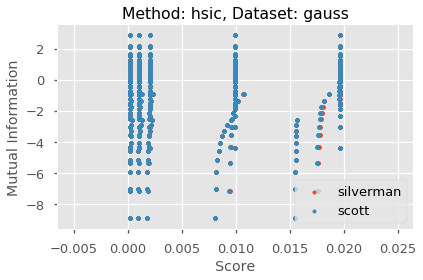

In [134]:
scorer = 'hsic'
dataset = 'gauss'

fig, ax = plot_individual_scores(scores_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")


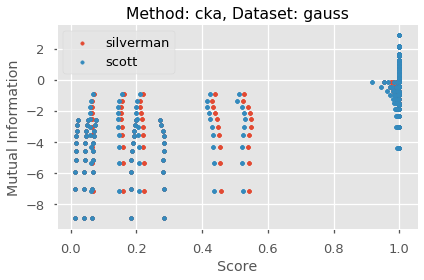

In [132]:
scorer = 'cka'
dataset = 'gauss'

fig, ax = plot_individual_scores(scores_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

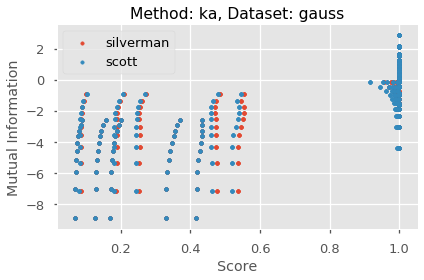

In [133]:
scorer = 'ka'
dataset = 'gauss'

fig, ax = plot_individual_scores(scores_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

#### Viz - Median Distances (Reasonable)

So for this, I will be looking at a few median distance values. This is the standard method so it will be good to compare.

In [91]:
[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]

[('median', 0.1, None),
 ('median', 0.2, None),
 ('median', 0.30000000000000004, None),
 ('median', 0.4, None),
 ('median', 0.5, None),
 ('median', 0.6, None),
 ('median', 0.7000000000000001, None),
 ('median', 0.8, None),
 ('median', 0.9, None)]

In [113]:
demo_params = [
    ('median', 0.30000000000000004, None),
    ('median', 0.5, None),
    ('median', 0.7000000000000001, None),
]
demo_params = [('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]

In [ ]:
projects/2019_hsic_align/results/figures/distribution_experiment/mutual_info

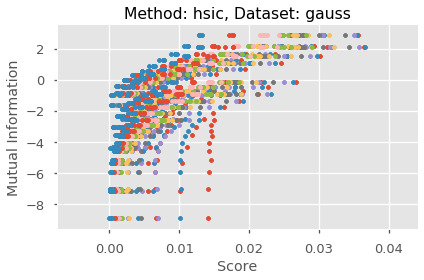

In [124]:
scorer = 'hsic'
dataset = 'gauss'

fig, ax = plot_individual_scores(scores_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")


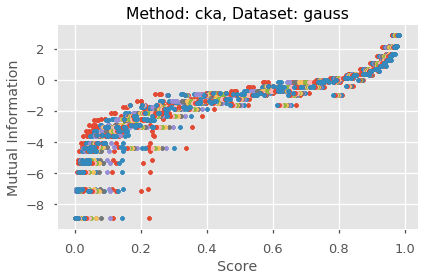

In [125]:
scorer = 'cka'
dataset = 'gauss'

fig, ax = plot_individual_scores(scores_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

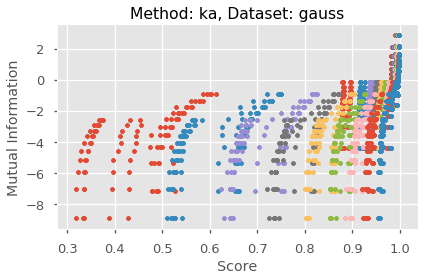

In [126]:
scorer = 'ka'
dataset = 'gauss'
fig, ax = plot_individual_scores(scores_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

In [170]:
s = gamma_ests_df[gamma_ests_df['gamma_method'] == gamma_estimators[0][0]]
s = s[s['gamma_method'] == gamma_estimators[0][1]]
s

,gamma_X,gamma_Y,gamma_method,gamma_percent,gamma_scale,score,scorer


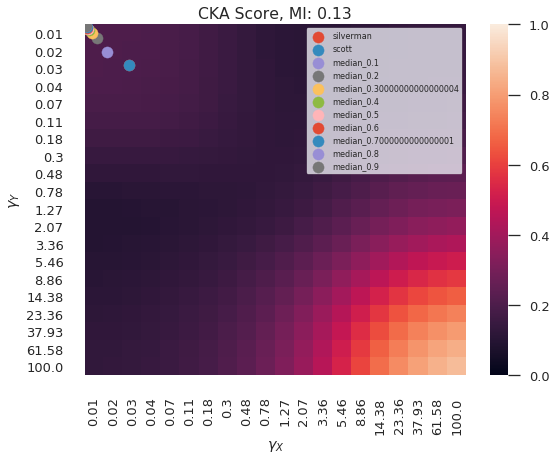

In [172]:

# ==========================
# Centered Kernel Alignment
# ==========================
scorer = 'cka'

# Plot Grid
fig, ax = plot_gamma_grid(param_df, scorer=scorer)

# Plot points
ax = plot_estimated_params(ax, gamma_ests_df, gamma_estimators, scorer, )

ax.legend(ncol=1, fontsize=8)
ax.set_xlabel(r'$\gamma_X$')
ax.set_ylabel(r'$\gamma_Y$')
ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
plt.tight_layout()
plt.show()

### Viz - Combined Function


In [174]:
def plot_dist_params(param_df, gamma_ests_df, gamma_estimators, scorer: str):

    # Plot Grid
    fig, ax = plot_gamma_grid(param_df, scorer=scorer)

    # Plot points
    ax = plot_estimated_params(ax, gamma_ests_df, gamma_estimators, scorer, )

    ax.legend(ncol=1, fontsize=8)
    ax.set_xlabel(r'$\gamma_X$')
    ax.set_ylabel(r'$\gamma_Y$')
    ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
    plt.tight_layout()
    plt.show()

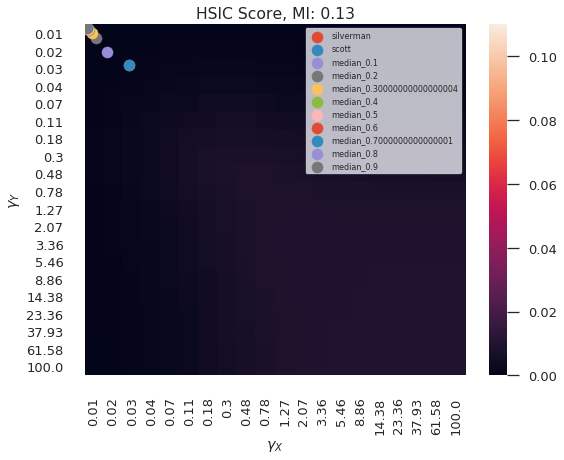

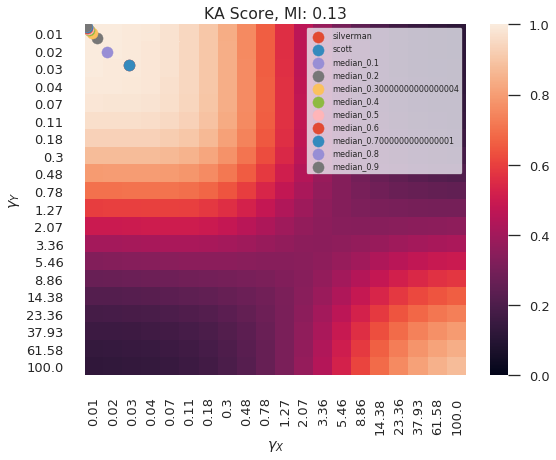

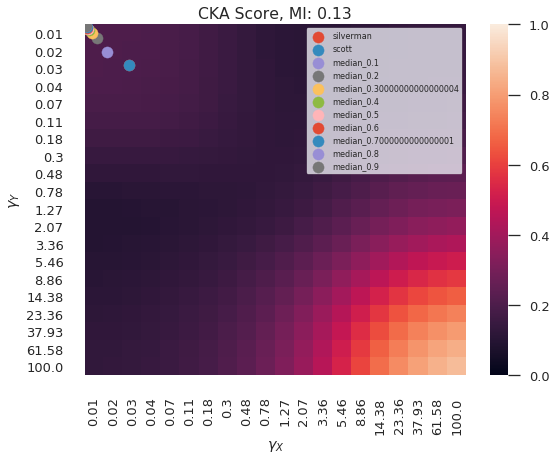

In [176]:

plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'hsic')
plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'ka')
plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'cka')


## Experiment II - Different Scorers, Initializations and Degree of Freedom

In this experiment, we'll be looking at how do the HSIC values change depending upon the gamma initialization as well as the degree of freedom we choose. In the Gaussian distribution, this is the standard deviation, $\sigma$ and the T-Student distribution this is the $\nu$ parameter.

In [25]:
from tqdm import trange, tqdm

In [27]:
# dataset params
dataset = 'gauss'
samples = 100
dimensions = 2
std = 1
trial = 1

# max params
n_gamma = 50
factor = 1

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
    ('max', None)
]
dof_params = np.linspace(1,11, 11, endpoint=True)

# results dataframe
results_df = pd.DataFrame()


# run experiment
with tqdm(gamma_methods) as gamma_bar:
    for imethod in gamma_bar:
        for iscorer in scorers:
            for idof in dof_params:

                # extract dataset
                X, Y, mi_val = MIData(dataset).get_data(samples=samples, dimensions=dimensions, std=int(idof), trial=trial)

                # initialize gamma
                if imethod[0] == 'max':
                    hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=True, n_gamma=n_gamma, factor=factor)
                else:
                    gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])
                    hsic_value = get_hsic(X, Y, iscorer, gamma_init)

                # append results to dataframe
                results_df = results_df.append({
                    'scorer': iscorer,
                    'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
                    'gamma_init': gamma_init,
                    'hsic_value': hsic_value,
                    'std': idof,
                    'mi_value': mi_val,
                }, ignore_index=True)

results_df.head()

100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


,gamma_init,gamma_method,hsic_value,mi_value,scorer,std
0,2.320794,silverman,0.008088,0.000000,hsic,1.0
1,2.320794,silverman,0.008068,0.002053,hsic,2.0
2,2.320794,silverman,0.008096,0.007718,hsic,3.0
3,2.320794,silverman,0.008163,0.016467,hsic,4.0
4,2.320794,silverman,0.008259,0.027999,hsic,5.0


In [61]:
# plot the results
from typing import Tuple, List, Optional
def plot_scorer_mi(df: pd.DataFrame, scorer: str, dataset: str, omit_methods: Optional[Tuple[str, List[str]]]=None)-> None:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
    # extract dataset
    df = df[df['dataset'] == dataset]
    
    # omit methods
    if omit_methods is not None:
        df = df[~df[omit_methods[0]].isin(omit_methods[1])]
    
    # plot
    sns.scatterplot(
        x='hsic_value', 
        y='mi_value',
        hue='gamma_method',
        data=df[df['scorer'] == scorer],
        ax=ax
    )
    ax.set_ylabel('Mutual Information')
    ax.set_xlabel('Score')
    ax.legend(prop={'size':9})
    ax.set_title(scorer.upper())
    plt.show()

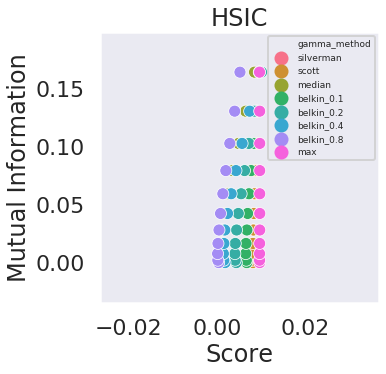

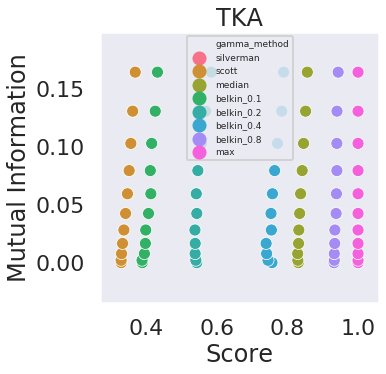

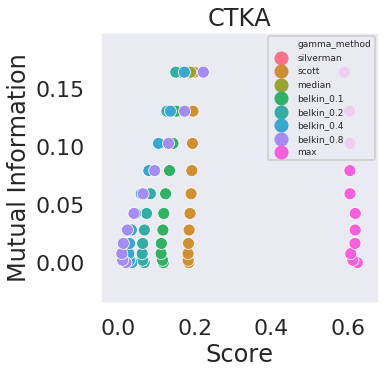

In [29]:
plot_scorer_mi(results_df, 'hsic')
plot_scorer_mi(results_df, 'tka')
plot_scorer_mi(results_df, 'ctka')

### Same Experiment, but with a higher number of samples and dimensions

In [70]:
# dataset params
datasets = ['tstudent', 'gauss']
samples = [100, 500]
dimensions = [2]
trials = [1]

# max params
n_gamma = 50
factor = 1

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
    ('max', None)
]
std_params = np.linspace(1,11, 11, endpoint=True, dtype=int)
nu_params = np.linspace(1,9, 9, endpoint=True, dtype=int)

# results dataframe
results_df = pd.DataFrame()



        
# loop through datasets
for idataset in datasets:
    # run experiment
    with tqdm(gamma_methods) as gamma_bar:

        # Loop through Gamma params
        for imethod in gamma_bar:
            # Loop through samples
            for isample in samples:
                
                # Loop through dimensions
                for idim in dimensions:
                    
                    # Loop through trials
                    for itrial in trials:
                        
                        # Loop through HSIC scorers
                        for iscorer in scorers:

                            # extract dataset
                            if idataset == 'gauss':
                                dof_params = std_params
                            else:
                                dof_params = nu_params
                            
                            # Loop through dof params
                            for idof in dof_params:
                                
                                X, Y, mi_val = MIData(idataset).get_data(samples=isample, dimensions=idim, std=idof, nu=idof, trial=itrial)

                                # initialize gamma
                                if imethod[0] == 'max':
                                    hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=True, n_gamma=n_gamma, factor=factor)
                                else:
                                    gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])
                                    hsic_value = get_hsic(X, Y, iscorer, gamma_init)

                                # append results to dataframe
                                results_df = results_df.append({
                                    'dataset': idataset,
                                    'samples': isample,
                                    'dimensions': idim,
                                    'trial': itrial,
                                    'scorer': iscorer,
                                    'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
                                    'gamma_init': gamma_init,
                                    'hsic_value': hsic_value,
                                    'dof': idof,
                                    'mi_value': mi_val,
                                }, ignore_index=True)
                            
                    postfix = dict(Samples=f"{isample}", Dimensions=f"{idim}")
                    gamma_bar.set_postfix(postfix)

results_df.head()

100%|██████████| 8/8 [00:32<00:00,  4.05s/it, Samples=500, Dimensions=2]


,dataset,dimensions,dof,gamma_init,gamma_method,hsic_value,mi_value,samples,scorer,trial
0,tstudent,2.0,1.0,2.320794,silverman,0.009819,0.302042,100.0,hsic,1.0
1,tstudent,2.0,2.0,2.320794,silverman,0.008801,0.136519,100.0,hsic,1.0
2,tstudent,2.0,3.0,2.320794,silverman,0.008473,0.079458,100.0,hsic,1.0
3,tstudent,2.0,4.0,2.320794,silverman,0.008517,0.052638,100.0,hsic,1.0
4,tstudent,2.0,5.0,2.320794,silverman,0.008267,0.037823,100.0,hsic,1.0


In [71]:
res_high_df = results_df.copy()

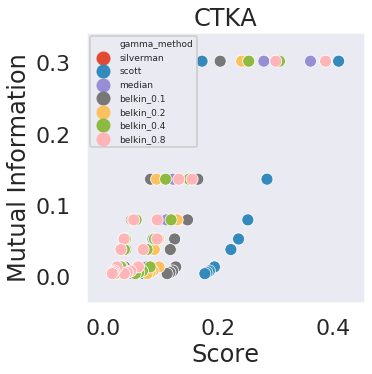

In [75]:
plot_scorer_mi(res_high_df, 'ctka', 'tstudent', ('gamma_method', ['max', ]))
# plot_scorer_mi(res_high_df, 'tka', 'tstudent')
# plot_scorer_mi(res_high_df, 'ctka', 'tstudent')